In [1]:
training_data_directory = '/kaggle/input/soil-dataset/train'
test_data_directory = '/kaggle/input/soil-dataset/test'
validation_data_directory = '/kaggle/input/soil-dataset/validation'

In [2]:
import os
import re
import cv2
import time
import shutil
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# FINDING FILES

In [3]:
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)
validation_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)
validation_data = validation_data_processor.flow_from_directory(
    validation_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 150 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# MODEL BUILDING

In [4]:
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 100
MODEL_NAME = 'soil'

In [5]:
model = Sequential()
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy','Precision','Recall'],
                )
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data=testing_data,)

model.save(f'{MODEL_NAME}.h5')

2023-02-07 14:26:27.144161: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-07 14:26:28.151759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 3.4948 - accuracy: 0.4000 - precision: 0.3617 - recall: 0.2267 - val_loss: 1.1530 - val_accuracy: 0.2222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 5s 894ms/step - loss: 1.1247 - accuracy: 0.3533 - precision: 0.7391 - recall: 0.1133 - val_loss: 1.0547 - val_accuracy: 0.3333 - val_precision: 1.0000 - val_recall: 0.0556
Epoch 3/100
5/5 [==============================] - 5s 881ms/step - loss: 1.0326 - accuracy: 0.4533 - precision: 1.0000 - recall: 0.0400 - val_loss: 0.9772 - val_accuracy: 0.3889 - val_precision: 1.0000 - val_recall: 0.3333
Epoch 4/100
5/5 [==============================] - 5s 897ms/step - loss: 0.9417 - accuracy: 0.5333 - precision: 0.9111 - recall: 0.2733 - val_loss: 0.8146 - val_accuracy: 0.6111 - val_precision: 0.8571 - val_recall: 0.3333
Epoch 5/100
5/5 [==============================] - 5s 966ms/step - loss: 0.7926 - accuracy: 0.5933 - pr

In [6]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/kaggle/working/soil.h5


# MODEL TESTING

In [7]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp)
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. 
    img_batch = np.expand_dims(image_array, axis = 0)
    
    class_ = ["Gravel", "Sand", "Silt"] 
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]
    
    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


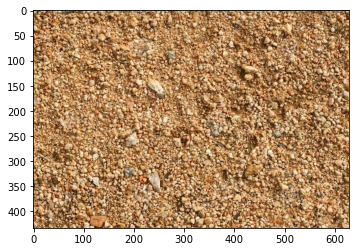

In [8]:
test_image_filepath = test_data_directory + r'/Sand/2.jpg'
print(make_prediction(test_image_filepath))

# PERCENTAGE OF A SOIL TYPE IN A MIXED SAMPLE

In [9]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

# DIVIDING ORIGINAL IMAGE INTO PORTIONS

In [10]:
try:
    parent = training_data_directory.replace('/kaggle/input/soil-dataset/train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('/kaggle/input/soil-dataset/train', 'train_divided'))
    
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('/kaggle/input/soil-dataset/test', 'test_divided'))
except FileExistsError:
    pass

In [11]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/kaggle/working/soil.h5


In [12]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array

def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 840.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))
    
    im = cv2.imread(image_fp)
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')


# PERCENTAGE OF EACH SOIL TYPE IN A SAMPLE

---
Percent Gravel: 0.0%)
Percent Sand: 0.0%)
Percent Silt: 100.0%)
Time to Classify: 0.79986 seconds
---


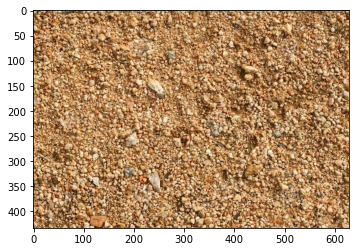

In [13]:
percentage_photo = test_data_directory + r"/Sand/2.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])
classify_percentage(image_fp=percentage_photo)

# PIPELINE


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder



In [15]:
steps = [("imputation constant",SimpleImputer(fill_value="not available",strategy ="constant")),
         ("onehot",OneHotEncoder(handle_unknown="ignore"))]

In [16]:
mypipe = Pipeline(steps)

In [17]:
from sklearn import set_config
set_config(display="diagram")



In [18]:
mypipe

Pipeline(steps=[('imputation constant',
                 SimpleImputer(fill_value='not available',
                               strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])